# Exploratory Analysis Phishing_Email.csv Group 3

In [89]:
# Potentionally helpful libraries:
# pandas, matplotlib, seaborn, nltk, scikit-learn, gensim, pyLDAvis

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

## Data Cleaning Function

In [90]:
#function now cleans the dataframe of null and empty emails and prints a pie chart that
# showcases the percent of null and empty emails vs. 'good' emails (non-null and anon-empty)
def make_df():
    # Reading in the data
    df = pd.read_csv("Phishing_Email.csv")
    # Dropping the unecessary index row
    df = df.drop(df.columns[0], axis=1)
    
    #calculate counts before cleaning
    num_rows = df.shape[0]
    num_nulls = df['Email Text'].isnull().sum()
    num_emptys = (df['Email Text'].str.lower() == 'empty').sum()
    num_not_empty_and_not_null = num_rows - num_nulls - num_emptys
    
    # Removing Nulls
    # Check for null values in the "Email Text" column
    null_mask = df["Email Text"].isnull()

    # If there are null values, drop the corresponding rows
    if null_mask.any():
        df = df.drop(df[null_mask].index)
        
    #Remove 'empty' emails from the dataframe
    df_cleaned = df[df['Email Text'].str.lower() != 'empty']
    df = df_cleaned
    
    #plotting data
    labels = 'Null Values', ' Empty Emails', 'Non-Empty and Non-Null Emails'
    sizes = [num_nulls, num_emptys, num_not_empty_and_not_null]
    colors = ['red', 'lightcoral', 'lightskyblue']
    explode = (0.1,0.1,0)   #explode 1st and 2nd labels, since their number is smaller compared to the third
    plt.figure(figsize=(10,6))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, shadow=True, startangle=140)
    plt.axis('equal')
    plt.title('Proportion of Null, Empty and Non-Null and Non-Empty emails in dataset')
    plt.show()
    
    return df

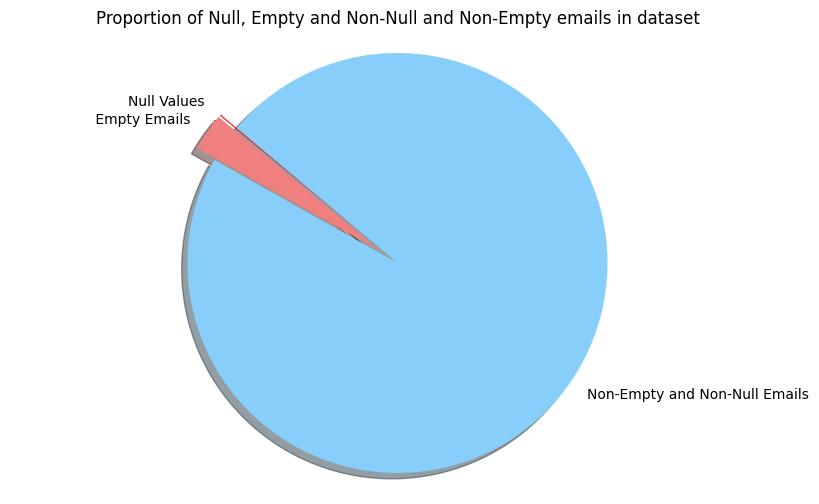

In [91]:
#gets cleaned dataframe and prints plot
df_phish = make_df()

In [92]:
df_phish.shape

(18101, 2)

As we can see the number of 'good' emails (non-empty and non-null) dominate the dataset. While the number of empty and null values in the dataset is very low, we make sure to take them out in order to avoid any issues with our feature extraction and analyses. It can also be seen that the proportion of null values as a whole is very miniscule compared to the proprtion of empty emails and good emails.

## Feature Extraction

### Emails with "re:"

In [93]:
print(df_phish.tail(5))

def countNaN(df):
    return (df["Email Text"] == "NaN").sum()

print(countNaN(df_phish))

                                              Email Text      Email Type
18644  \nRick Moen  a Ã©crit:> > I'm confused. I thou...      Safe Email
18645  date a lonely housewife always wanted to date ...  Phishing Email
18646  request submitted : access request for anita ....      Safe Email
18647  re : important - prc mtg hi dorn & john , as y...      Safe Email
18648  press clippings - letter on californian utilit...      Safe Email
0


In [94]:
print(df_phish.tail(20))
# Adding "Is_Response" feature
df_phish["Is_Response"] = df_phish["Email Text"].str.contains("re :")
print(df_phish.tail(20))

                                              Email Text      Email Type
18627  crying mlcros 0 ft , symanntec , macromedia , ...  Phishing Email
18628  Has anybody on the list installed/used this di...      Safe Email
18629  re : 6 . 923 , sum : chomsky on letting the th...      Safe Email
18630  s . hattori dies this is the english version o...      Safe Email
18631  Update of /cvsroot/spamassassin/spamassassin\n...      Safe Email
18632  weekly deal report this is the weekly report c...      Safe Email
18633  This article from NYTimes.com \nhas been sent ...      Safe Email
18634  congratulations you have won ! ! ! pls contact...  Phishing Email
18635  On Fri, 4 Oct 2002, Mark Derricutt wrote:> Any...      Safe Email
18636  prior month misnomination daren - - - - for 4 ...      Safe Email
18638  strong buy alert : monthly newsletter topstock...  Phishing Email
18639  out of office i have an appointment today and ...      Safe Email
18640  list of english taboo words does anyone have

In [95]:
df_phish["Is_Response"].value_counts(normalize=True)

Is_Response
False    0.866637
True     0.133363
Name: proportion, dtype: float64

### Emails with links

In [96]:
# This is causing columns to turn into NaN values and losing data.

print(df_phish.tail(5))
# Adding "Has_WebLink" column
df_phish["Has_WebLink"] = df_phish["Email Text"].str.contains('(https?://|www.)')

#think about adding http check for tagging emails with http
url_pattern = r'(https?://\S+|www\.\S+)'

# Extract hyperlinks from the Email Text column and store them in a new column "WebLink"
df_phish['WebLink'] = df_phish['Email Text'].str.extractall(url_pattern)[0].groupby(level=0).agg(', '.join)


print(df_phish.tail(20))
    

                                              Email Text      Email Type  \
18644  \nRick Moen  a Ã©crit:> > I'm confused. I thou...      Safe Email   
18645  date a lonely housewife always wanted to date ...  Phishing Email   
18646  request submitted : access request for anita ....      Safe Email   
18647  re : important - prc mtg hi dorn & john , as y...      Safe Email   
18648  press clippings - letter on californian utilit...      Safe Email   

       Is_Response  
18644        False  
18645         True  
18646        False  
18647         True  
18648        False  


C:\Users\danie\AppData\Local\Temp\ipykernel_11600\3246346750.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_phish["Has_WebLink"] = df_phish["Email Text"].str.contains('(https?://|www.)')


                                              Email Text      Email Type  \
18627  crying mlcros 0 ft , symanntec , macromedia , ...  Phishing Email   
18628  Has anybody on the list installed/used this di...      Safe Email   
18629  re : 6 . 923 , sum : chomsky on letting the th...      Safe Email   
18630  s . hattori dies this is the english version o...      Safe Email   
18631  Update of /cvsroot/spamassassin/spamassassin\n...      Safe Email   
18632  weekly deal report this is the weekly report c...      Safe Email   
18633  This article from NYTimes.com \nhas been sent ...      Safe Email   
18634  congratulations you have won ! ! ! pls contact...  Phishing Email   
18635  On Fri, 4 Oct 2002, Mark Derricutt wrote:> Any...      Safe Email   
18636  prior month misnomination daren - - - - for 4 ...      Safe Email   
18638  strong buy alert : monthly newsletter topstock...  Phishing Email   
18639  out of office i have an appointment today and ...      Safe Email   
18640  list 

In [97]:
df_phish["Has_WebLink"].value_counts(normalize=True)

Has_WebLink
False    0.660682
True     0.339318
Name: proportion, dtype: float64

### Email Length

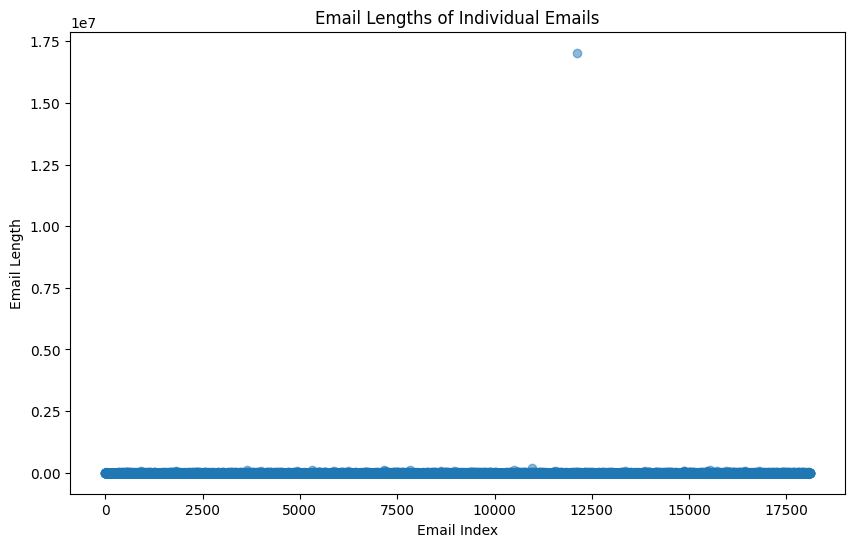

In [98]:
# print(df_phish.tail(5))

# Creating the Email Length Column
df_phish["Email_Length"] = df_phish["Email Text"].str.len()

#plotting scatter plot 
plt.figure(figsize=(10, 6))
plt.scatter(x=range(len(df_phish)), y=df_phish["Email_Length"], alpha=0.5)
plt.title('Email Lengths of Individual Emails')
plt.xlabel('Email Index')
plt.ylabel('Email Length')
plt.show()
    
# Verifying it worked
# print(df_phish.tail(5))


Initial drawing of the scatter plot shows that we have an outlier, which blasts the range of the plot into 10^7.

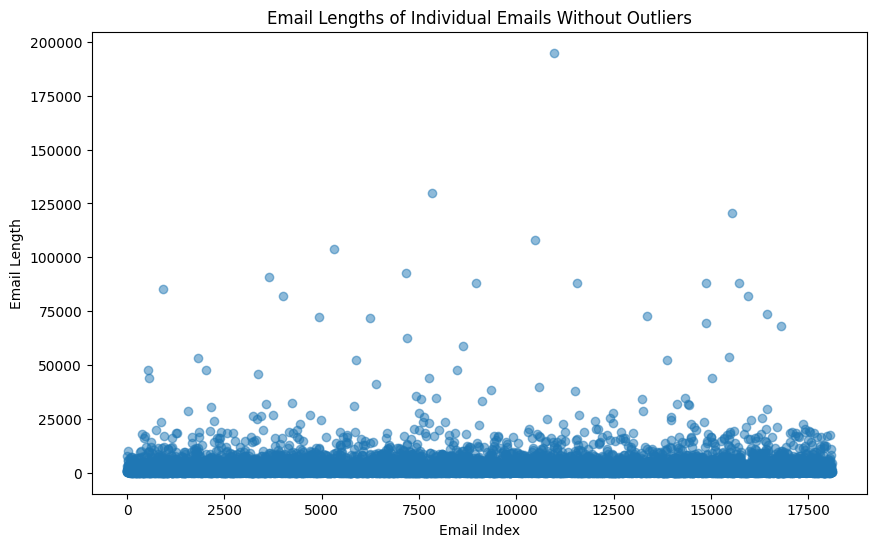

In [99]:

length_threshold = 0.2e7

# Filtering the DataFrame to exclude the outlier
df_filtered = df_phish[df_phish["Email_Length"] < length_threshold]

plt.figure(figsize=(10, 6))
plt.scatter(x=range(len(df_filtered)), y=df_filtered["Email_Length"], alpha=0.5, label='Emails')
plt.title('Email Lengths of Individual Emails Without Outliers')
plt.xlabel('Email Index')
plt.ylabel('Email Length')
plt.show()

As can be seen in this plot without the outlier, most of the emails in the dataset are under 25000 characters in length, while we have comparatively few emails larger than that. This can be seen even more clearly through a histogram:

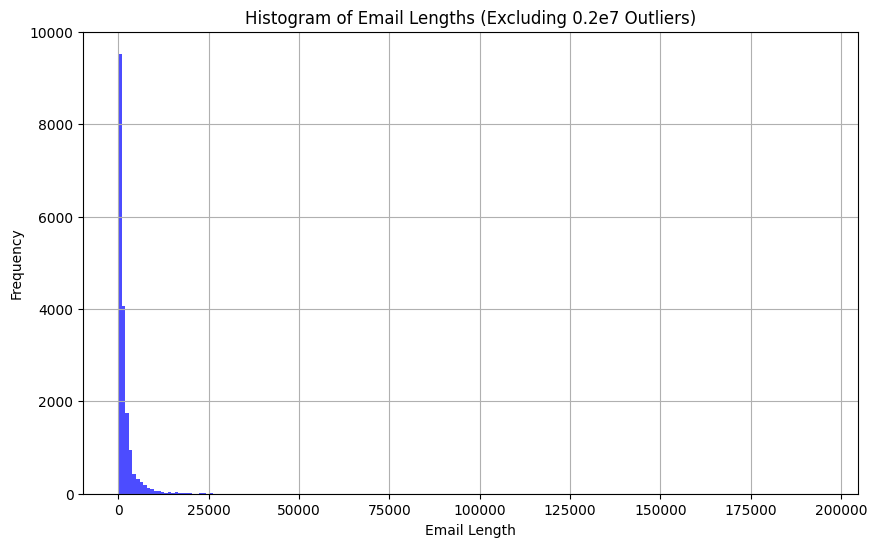

In [100]:
# Plotting histogram of email lengths with filtered data
plt.figure(figsize=(10, 6))
plt.hist(df_filtered["Email_Length"], bins=200, color='blue', alpha=0.7)
plt.title('Histogram of Email Lengths (Excluding 0.2e7 Outliers)')
plt.xlabel('Email Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


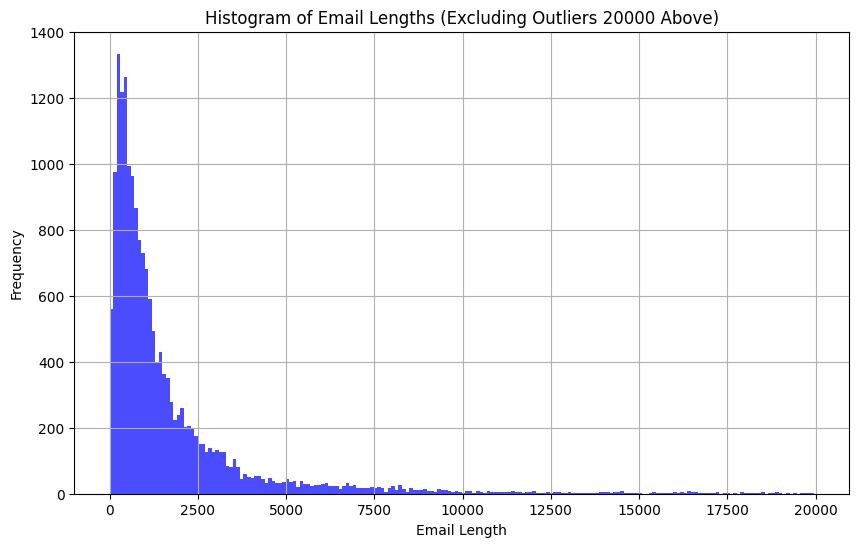

In [101]:

length_threshold = 20000

# Filtering the DataFrame to exclude anything above 50000 to see the spread below that
df_filtered_20000 = df_phish[df_phish["Email_Length"] < length_threshold]
# Plotting histogram of email lengths with double filtered data
plt.figure(figsize=(10, 6))
plt.hist(df_filtered_20000["Email_Length"], bins=200, color='blue', alpha=0.7)
plt.title('Histogram of Email Lengths (Excluding Outliers 20000 Above)')
plt.xlabel('Email Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Special Characters in Emails

In [102]:
# Create a new column to count accented vowels
df_phish["accentChar_count"] = df_phish["Email Text"].str.count(r'[àáâãäåæçèéêëìíîïðñòóôõöøùúûüýÿ]')
df_phish["accentChar_percentage"] = df_phish["accentChar_count"]*100/df_phish["Email_Length"]
# Describe the distribution of accented vowels count
accent_count_stats = df_phish["accentChar_percentage"].describe()
print(accent_count_stats)


count    18101.000000
mean         0.057935
std          1.022729
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         28.790103
Name: accentChar_percentage, dtype: float64


In [103]:
# Filter the DataFrame for entries with accent count > 1
filtered_df = df_phish[df_phish["accentChar_count"] > 1]

print("There are",filtered_df.shape[0],"emails with special characters with accents.")


There are 331 emails with special characters with accents.


In [104]:
print(df_phish.tail(10))

df_phish["Hyphen_Count"] = df_phish["Email Text"].str.count(r"-")
df_phish["Pound_Count"] = df_phish["Email Text"].str.count(r"#")
df_phish["At_Count"] = df_phish["Email Text"].str.count(r"@")

print(df_phish.tail(10))

                                              Email Text      Email Type  \
18638  strong buy alert : monthly newsletter topstock...  Phishing Email   
18639  out of office i have an appointment today and ...      Safe Email   
18640  list of english taboo words does anyone have a...      Safe Email   
18641  interview with the enron research group good m...      Safe Email   
18642  URL: http://diveintomark.org/archives/2002/09/...      Safe Email   
18644  \nRick Moen  a Ã©crit:> > I'm confused. I thou...      Safe Email   
18645  date a lonely housewife always wanted to date ...  Phishing Email   
18646  request submitted : access request for anita ....      Safe Email   
18647  re : important - prc mtg hi dorn & john , as y...      Safe Email   
18648  press clippings - letter on californian utilit...      Safe Email   

       Is_Response  Has_WebLink  \
18638        False        False   
18639        False        False   
18640        False        False   
18641        False     

In [105]:
print(df_phish.tail(10))

df_phish["Exclamation_Count"] = df_phish["Email Text"].str.count(r"!")
df_phish["Question_Count"] = df_phish["Email Text"].str.count(r"\?")
df_phish["Period_Count"] = df_phish["Email Text"].str.count(r"\.")

print(df_phish.tail(10))

                                              Email Text      Email Type  \
18638  strong buy alert : monthly newsletter topstock...  Phishing Email   
18639  out of office i have an appointment today and ...      Safe Email   
18640  list of english taboo words does anyone have a...      Safe Email   
18641  interview with the enron research group good m...      Safe Email   
18642  URL: http://diveintomark.org/archives/2002/09/...      Safe Email   
18644  \nRick Moen  a Ã©crit:> > I'm confused. I thou...      Safe Email   
18645  date a lonely housewife always wanted to date ...  Phishing Email   
18646  request submitted : access request for anita ....      Safe Email   
18647  re : important - prc mtg hi dorn & john , as y...      Safe Email   
18648  press clippings - letter on californian utilit...      Safe Email   

       Is_Response  Has_WebLink  \
18638        False        False   
18639        False        False   
18640        False        False   
18641        False     

In [106]:
# Summary Statistics for Special Characters
print(df_phish[["Exclamation_Count", "Hyphen_Count", "Question_Count", "Period_Count"]].describe())


       Exclamation_Count   Hyphen_Count  Question_Count   Period_Count
count       18101.000000   18101.000000    18101.000000   18101.000000
mean            2.512403      29.680128        1.965969      33.324402
std           107.005250    1235.000270       55.631281    1509.053526
min             0.000000       0.000000        0.000000       0.000000
25%             0.000000       1.000000        0.000000       5.000000
50%             0.000000       4.000000        0.000000      10.000000
75%             1.000000      15.000000        1.000000      21.000000
max         14368.000000  165989.000000     6096.000000  202811.000000


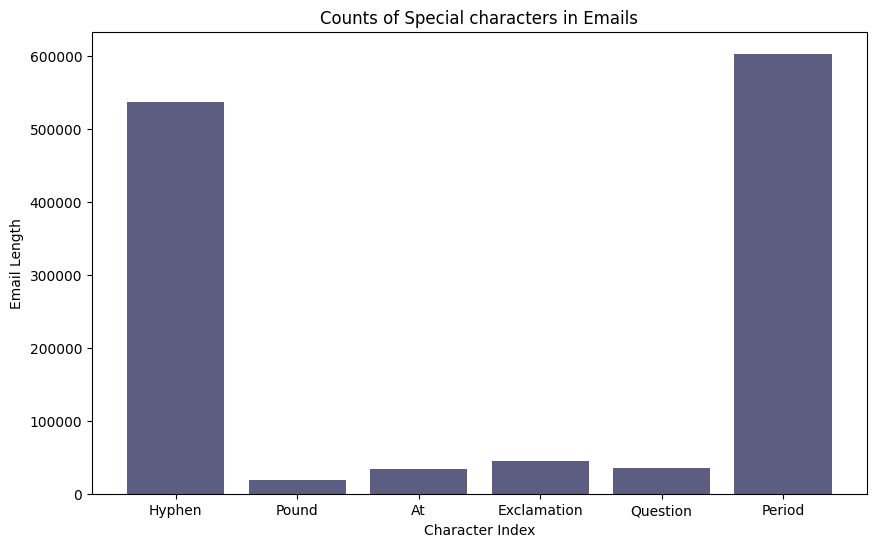

In [107]:
#creating a barchart for each special character category

#lists holds the labels and their respective counts
special_chars_labels = ["Hyphen","Pound", "At", "Exclamation", "Question", "Period"]
special_chars_labels_count = [df_phish["Hyphen_Count"].sum(), df_phish["Pound_Count"].sum(), df_phish["At_Count"].sum(),
                              df_phish["Exclamation_Count"].sum(), df_phish["Question_Count"].sum(), df_phish["Period_Count"].sum()]

plt.figure(figsize=(10,6))
plt.bar(special_chars_labels,special_chars_labels_count, color='#5D5D81')
plt.title('Counts of Special characters in Emails')
plt.xlabel('Character Index')
plt.ylabel('Email Length')
plt.show()

As this chart shows, period is the most popular special characters followed by hyphens.

Notably, there is extreme skewness of the frequency of some symbols, but the spread looks similar between safe and unsafe emails. This is also likely highly correlatated with email length. A better measure may be frequency of use for a symbol divided by character count.

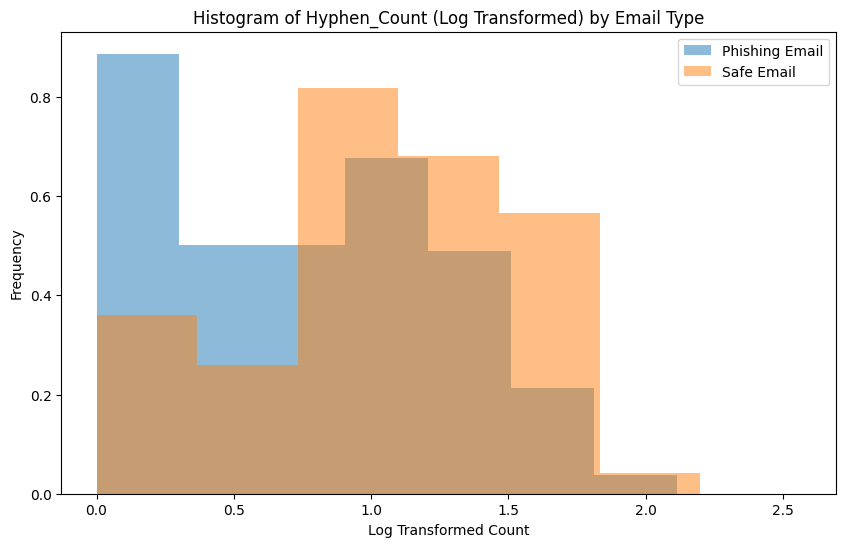

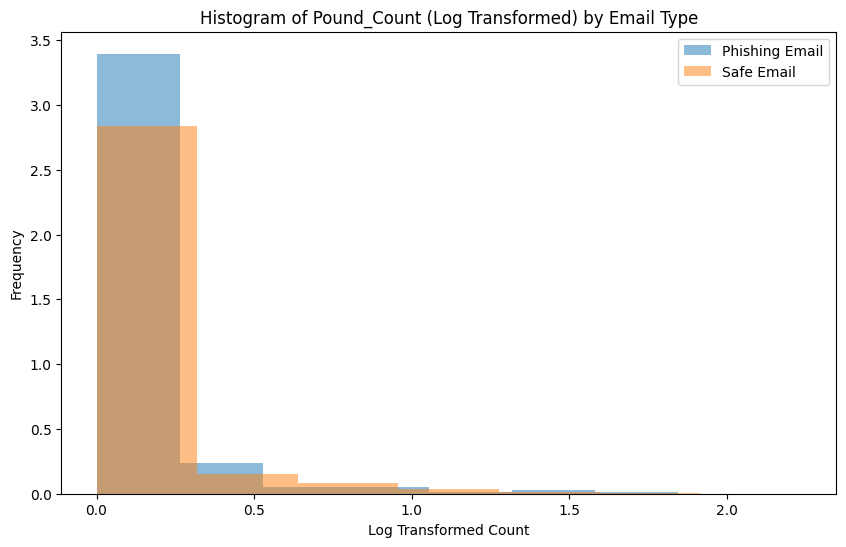

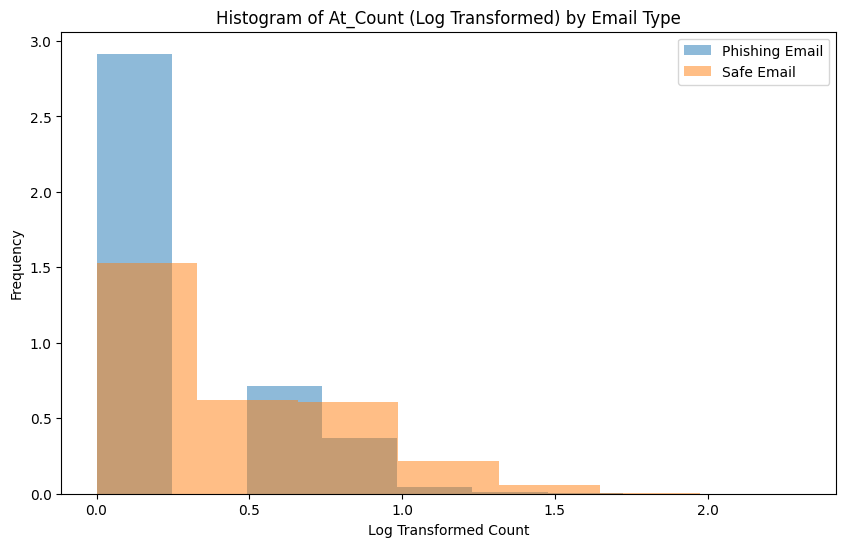

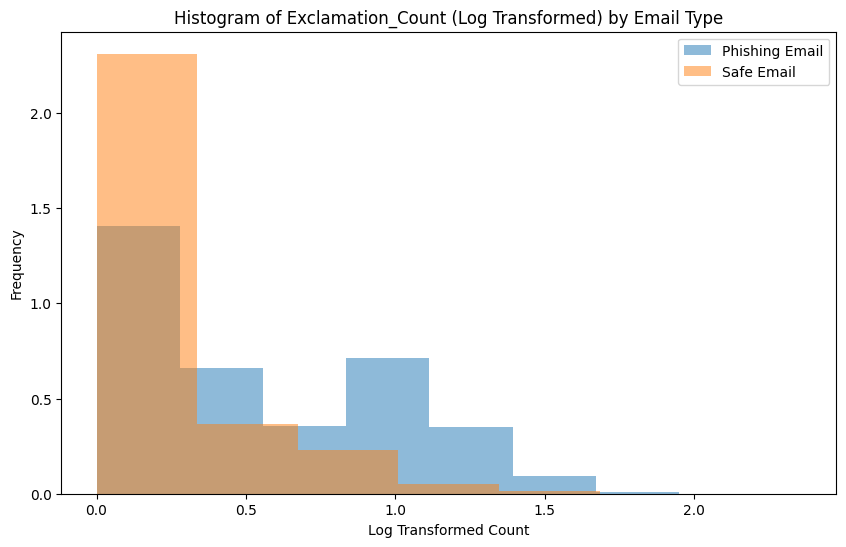

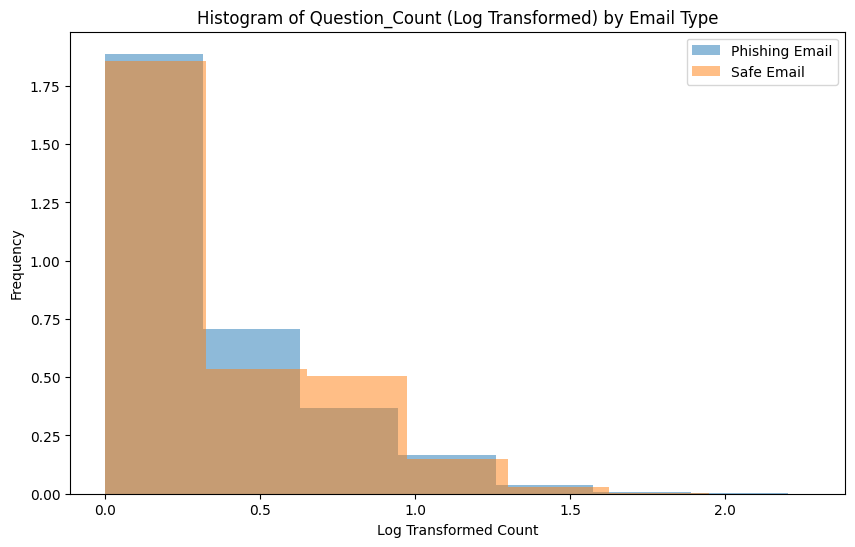

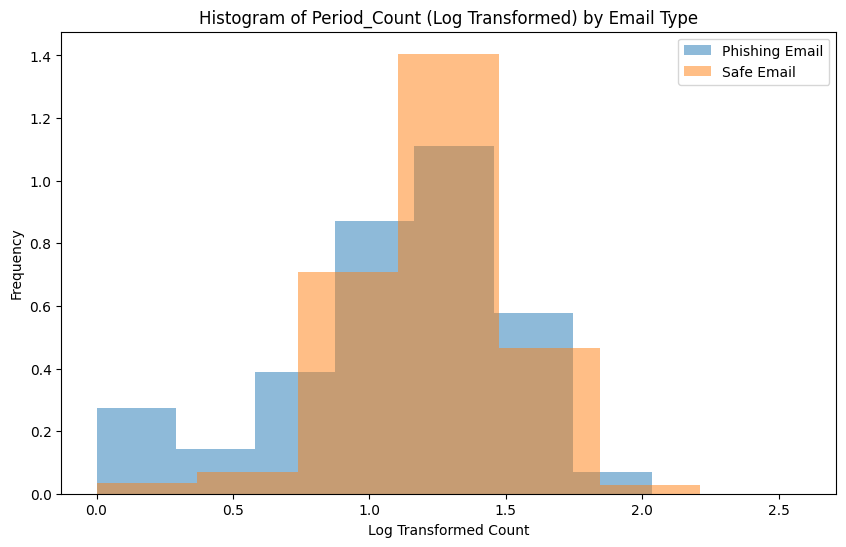

In [108]:
import numpy as np
# Apply logarithmic transformation to the data
df_phish_log = df_phish.copy()  # Create a copy of the DataFrame to avoid modifying the original data
special_chars_log = ["Hyphen_Count", "Pound_Count", "At_Count", "Exclamation_Count", "Question_Count", "Period_Count"]
df_phish_log[special_chars_log] = np.log1p(df_phish_log[special_chars_log])  # Apply logarithmic transformation

grouped = df_phish_log.groupby('Email Type')

# Plot histograms for each special character with logarithmic transformation
for char in special_chars_log:
    plt.figure(figsize=(10, 6))
    for name, group in grouped:
        plt.hist(np.log1p(group[char]), bins=7, alpha=0.5, label=name, density=True)  # Apply logarithmic transformation and normalize to percentages

    plt.title(f'Histogram of {char} (Log Transformed) by Email Type')
    plt.xlabel('Log Transformed Count')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


### Calculating the Frequency of Special Characters to Avoid a Multicolinearity issue with email length

In [109]:
# Calculate percentages for each special character
df_phish["Exclamation_Percentage"] = df_phish["Exclamation_Count"]*100 / df_phish["Email_Length"]
df_phish["Question_Percentage"] = df_phish["Question_Count"]*100 / df_phish["Email_Length"]
df_phish["Period_Percentage"] = df_phish["Period_Count"]*100 / df_phish["Email_Length"]

# Calculate percentages for additional special characters
df_phish["Hyphen_Percentage"] = df_phish["Hyphen_Count"]*100 / df_phish["Email_Length"]
df_phish["Pound_Percentage"] = df_phish["Pound_Count"]*100 / df_phish["Email_Length"]
df_phish["At_Percentage"] = df_phish["At_Count"]*100 / df_phish["Email_Length"]

# Describe the new columns only to verify the changes
print(df_phish[["Exclamation_Percentage", "Question_Percentage", "Period_Percentage", "Hyphen_Percentage", "Pound_Percentage", "At_Percentage"]].describe())



       Exclamation_Percentage  Question_Percentage  Period_Percentage  \
count            18101.000000         18101.000000       18101.000000   
mean                 0.155375             0.122016           1.295469   
std                  0.469260             0.794366           1.119670   
min                  0.000000             0.000000           0.000000   
25%                  0.000000             0.000000           0.770925   
50%                  0.000000             0.000000           1.091275   
75%                  0.120870             0.109449           1.579587   
max                 18.181818            66.297545          33.573141   

       Hyphen_Percentage  Pound_Percentage  At_Percentage  
count       18101.000000      18101.000000   18101.000000  
mean            1.228353          0.038269       0.086626  
std             2.445233          0.474457       0.228457  
min             0.000000          0.000000       0.000000  
25%             0.130890          0.000000

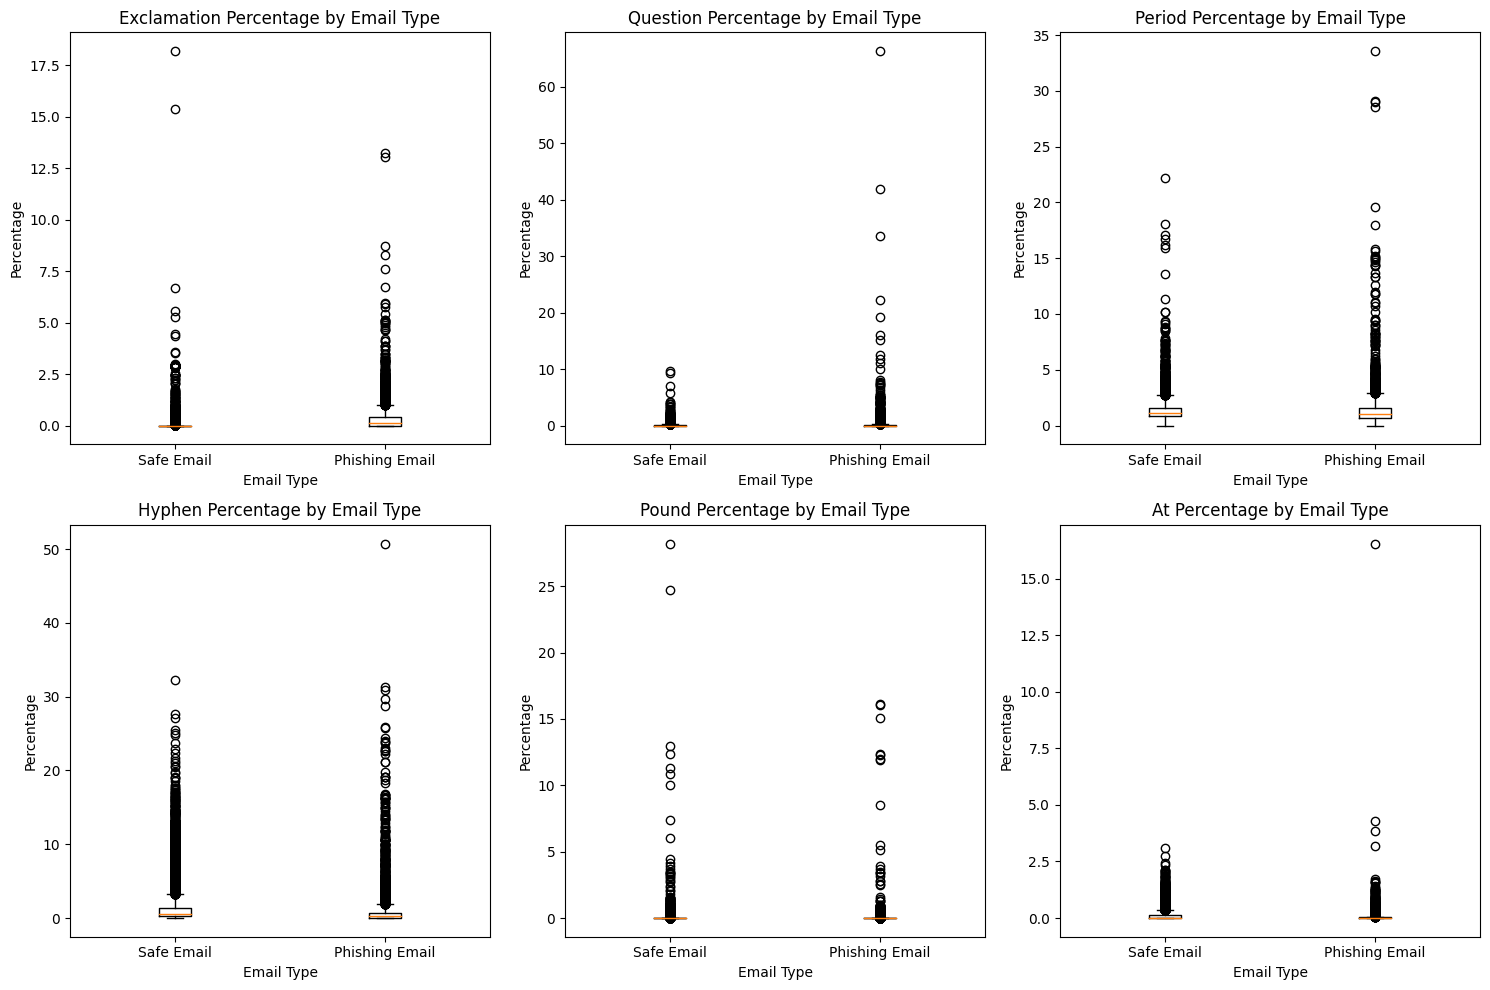

In [110]:
# Define the list of special characters
special_chars = ["Exclamation", "Question", "Period", "Hyphen", "Pound", "At"]

# Create subplots for each special character
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each special character
for i, char in enumerate(special_chars):
    # Group by Email Type and extract percentage data for the current special character
    grouped_data = [df_phish[df_phish['Email Type'] == email_type][f"{char}_Percentage"] for email_type in df_phish['Email Type'].unique()]
    
    # Create a boxplot for the current special character
    axes[i].boxplot(grouped_data, labels=df_phish['Email Type'].unique())
    axes[i].set_title(f'{char} Percentage by Email Type')
    axes[i].set_ylabel('Percentage')
    axes[i].set_xlabel('Email Type')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


### Emails with All-Caps characters over a certain percent threshold (8%) to determine safe or phishing emails

In [111]:
#writing a function that calculates the percent of upper and lowercase characters in an email

def percent_of_all_caps(text):
    if not text or not isinstance(text, str):
        return 0
    #getting rid of special characters from check for all-caps
    alphanumeric_text = re.sub(r'[^A-Za-z0-9]','',text)
    num_all_caps =  sum(1 for c in alphanumeric_text if c.isupper())
    num_total_characters = len(alphanumeric_text)
    #prevent divide by 0
    if(num_total_characters == 0):
        return 0
    percent_all_caps = (num_all_caps/num_total_characters)*100
    return percent_all_caps

#creating a new column in dataframe for percentage of capitalization and marking emails as safe or phishing
df_phish['Capitalization_Percent'] = df_phish['Email Text'].apply(percent_of_all_caps)

# I dont want to assume a percentage value that would be indicative of a phishing email or not just based on capitalization percentage.
# We should let the model determine that or make a graph showing at different percentages, what proportion of emails were correctly identified as phishing.
# df_phish['Is Phishing'] = df_phish['Capitalization_Percent'] > 8    #initially had as 55, looked at exported cleaned data to adjust to 8

#export in a CSV file to better compare my results on phishing classification vs. actual results
# temp_df = df_phish[['Email Text', 'Email Type', 'Capitalization_Percent', 'Is Phishing']]
#temp_df.to_csv('test.csv', index=False)
#print(temp_df)

count    18101.000000
mean         2.279874
std          5.225664
min          0.000000
25%          0.000000
50%          0.000000
75%          3.553299
max         99.506173
Name: Capitalization_Percent, dtype: float64


array([<Axes: title={'center': 'Phishing Email'}>,
       <Axes: title={'center': 'Safe Email'}>], dtype=object)

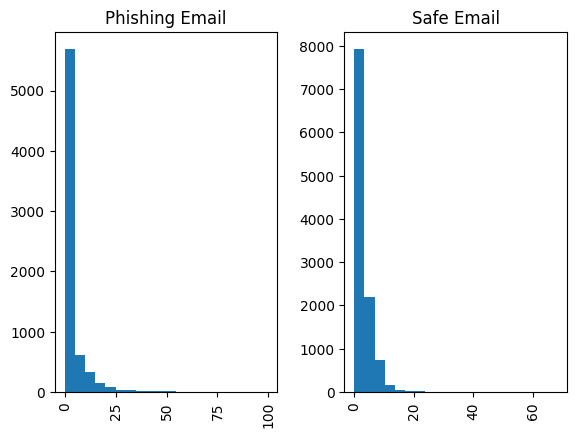

In [112]:
# Summary Statistics and Graph for New Column
print(df_phish["Capitalization_Percent"].describe())
df_phish["Capitalization_Percent"].hist(bins=20,by=df_phish["Email Type"])

## Multicolinearity?
How do we make sure that we are not double-counting the effect of a factor in a model? If two factors are highly correlated, then running a regression with both of them will lead to bias in our results. Therefore, we need to be aware of what factors are already highly correlated.

In [113]:
# Convert the "Email Type" column to string data type
df_phish["Email Type"] = df_phish["Email Type"].astype(str)

# Drop columns "Email Text" and "WebLink"
df_encoded = df_phish.drop(columns=["Email Text", "WebLink"])

# Replace string values with integers in "Email Type" column
df_encoded["Safe_Email"] = df_phish["Email Type"].map({"Safe Email": 1, "Phishing Email": 0})

# Drop the "Email Type" column
df_encoded = df_encoded.drop(columns=["Email Type"])

# Convert "Safe_Email" column to int type
df_encoded["Safe_Email"] = df_encoded["Safe_Email"].astype(int)

# Print to verify
print(df_encoded["Safe_Email"].tail())


18644    1
18645    0
18646    1
18647    1
18648    1
Name: Safe_Email, dtype: int32


### Importing Sentiment Analysis Column

In [114]:
# Sentiment analysis DataFrame
df_sentiment = pd.read_csv("Sentiment_Analysis_Export_df.csv")
df_sentiment.tail()

,Email Text,Email Type,Tokenized_Text,Sentiment_Score
18096,\nRick Moen a Ã©crit:> > I'm confused. I thou...,Safe Email,"['rick', 'moen', 'ã©crit', 'im', 'confused', '...",0.9954
18097,date a lonely housewife always wanted to date ...,Phishing Email,"['date', 'lonely', 'housewife', 'always', 'wan...",-0.7906
18098,request submitted : access request for anita ....,Safe Email,"['request', 'submitted', 'access', 'request', ...",0.7579
18099,"re : important - prc mtg hi dorn & john , as y...",Safe Email,"['important', 'prc', 'mtg', 'hi', 'dorn', 'joh...",0.9194
18100,press clippings - letter on californian utilit...,Safe Email,"['press', 'clipping', 'letter', 'californian',...",0.6908


In [115]:
# Check the shapes of the DataFrames
print("Shape of df_encoded:", df_encoded.shape)
print("Shape of df_sentiment:", df_sentiment.shape)

# Check the content of df_sentiment
print("Head of df_sentiment:")
print(df_sentiment.head())

# Check the index of both DataFrames
print("Index of df_encoded:")
print(df_encoded.index)
print("Index of df_sentiment:")
print(df_sentiment.index)

# Check the column names of both DataFrames
print("Columns of df_encoded:")
print(df_encoded.columns)
print("Columns of df_sentiment:")
print(df_sentiment.columns)

# Check for missing values in df_sentiment
print("Missing values in df_sentiment:")
print(df_sentiment.isnull().sum())


Shape of df_encoded: (18101, 19)
Shape of df_sentiment: (18101, 4)
Head of df_sentiment:
                                          Email Text      Email Type  \
0  re : 6 . 1100 , disc : uniformitarianism , re ...      Safe Email   
1  the other side of * galicismos * * galicismo *...      Safe Email   
2  re : equistar deal tickets are you still avail...      Safe Email   
3  \nHello I am your hot lil horny toy.\n    I am...  Phishing Email   
4  software at incredibly low prices ( 86 % lower...  Phishing Email   

                                      Tokenized_Text  Sentiment_Score  
0  ['6', '1100', 'disc', 'uniformitarianism', '10...           0.9798  
1  ['side', 'galicismos', 'galicismo', 'spanish',...           0.4329  
2  ['equistar', 'deal', 'ticket', 'still', 'avail...           0.8591  
3  ['hello', 'hot', 'lil', 'horny', 'toy', 'one',...           0.9640  
4  ['software', 'incredibly', 'low', 'price', '86...           0.0534  
Index of df_encoded:
Index([    0,     1,     

array([<Axes: title={'center': 'Phishing Email'}>,
       <Axes: title={'center': 'Safe Email'}>], dtype=object)

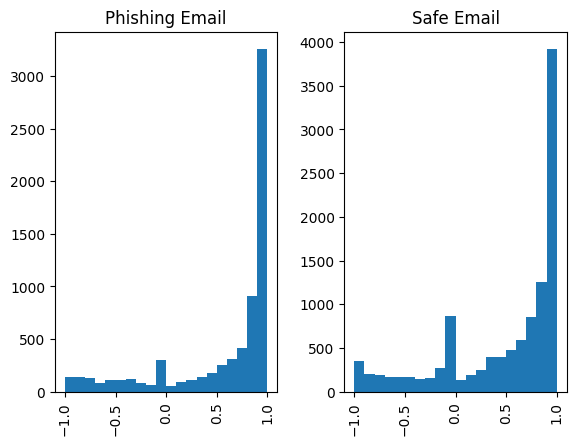

In [116]:
# Creating the Histogram of Sentiment Scores
df_sentiment["Sentiment_Score"].hist(bins=20,by=df_sentiment["Email Type"])


In [117]:
# Drop duplicate columns from df_sentiment
df_sentiment = df_sentiment.drop(["Email Text", "Email Type", "Tokenized_Text"], axis=1)
# Reset index to avoid index mismatch during concatenation
df_encoded.reset_index(drop=True, inplace=True)
# Concatenate df_sentiment with df_encoded along columns
df_encoded = pd.concat([df_sentiment, df_encoded], axis=1)

# verify

print(df_encoded.columns)


Index(['Sentiment_Score', 'Is_Response', 'Has_WebLink', 'Email_Length',
       'accentChar_count', 'accentChar_percentage', 'Hyphen_Count',
       'Pound_Count', 'At_Count', 'Exclamation_Count', 'Question_Count',
       'Period_Count', 'Exclamation_Percentage', 'Question_Percentage',
       'Period_Percentage', 'Hyphen_Percentage', 'Pound_Percentage',
       'At_Percentage', 'Capitalization_Percent', 'Safe_Email'],
      dtype='object')


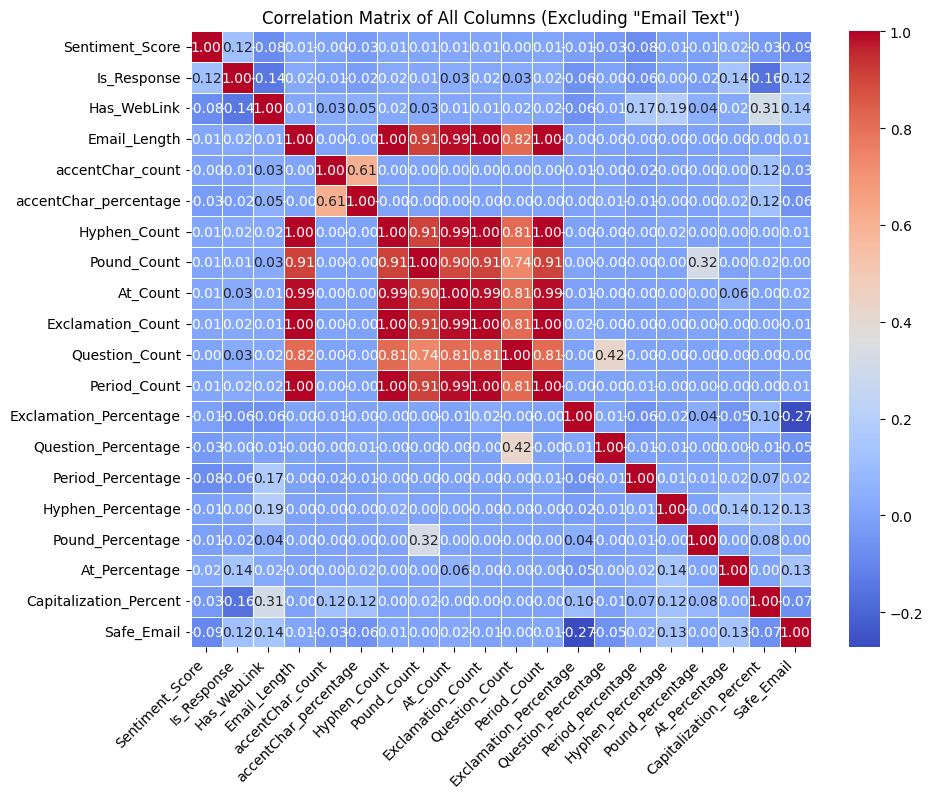

In [118]:
correlation_matrix = df_encoded.corr()
# Plotting the correlation matrix with rotated labels
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45,ha="right")

plt.title('Correlation Matrix of All Columns (Excluding "Email Text")')
plt.show()


The correlation shows a relatively low correlation on most factors, except for the email length and the counts. This issue is fixed by using the percentages.

## Exporting The Data

In [119]:
df_phish.to_csv("Post_EDA_df.csv",index=False)
df_encoded.to_csv("Post_EDA_encoded_df.csv",index=False)